# ラムゼイモデル

[蓮見 (2020)](https://www.nippyo.co.jp/shop/book/8267.html) §2.4 を元にしています。解き方は教科書の指示通りですが、技術進歩・人口成長を考慮できるようにモデルの仮定に少しだけ変更を加えています。

有名なモデルなので、適当な教科書を選んで丁寧に読めばここのモデルも再構築できて、[蓮見 (2020)](https://www.nippyo.co.jp/shop/book/8267.html) の説明もあながち特殊な仮定をおいている訳ではないと理解できると思います。ただ、離散時間ラムゼイモデルの説明はそもそもないか、あっても $\delta$, $g$, $n$ のどれかが省略されたりするので、「変数省略が手計算を簡単にするだけの仮定である」と納得できるまでには少し時間がかかるかもしれない。

一応、ここでも簡単にだけ説明しておきますが、すでに知っている人には分かるというくらいの説明になっていると思います。知らない人が理解するための説明がほしい、でも教科書を読むのは面倒だという人は [佐藤の講義ノート](https://github.com/kenjisato/MaD/blob/master/Lecture%20Notes/ch08.pdf) などを参照してください。

## 簡単な解説

効率労働1単位あたりの資本 $k$ と効率労働1単位あたりの消費 $c$ を

$$
k = \frac{K}{AL}, \quad c = \frac{c}{AL}, 
$$

と定義する。総生産関数 $(K, L, A) \mapsto Y$ が $(K, L)$ について1次同次で、技術 $A$ の成長が労働節約的であれば、効率労働1単位あたりの資本 $k$ から、効率労働1単位あたりの生産 $y = Y/(AL)$ を対応付ける関数を定義できる。つまり、

$$
y = f(k)
$$

この関数は $f(0) = 0$, $f'(k) > 0$, $f''(k) < 0$ などのオーソドックスな生産関数の仮定を満たすものとする。端点条件を排除するために、原点での微係数は十分大きくて、無限遠点での微係数は十分小さいものとする（稲田条件は便利だけど必要ではない）。もともとの生産関数 $Y = F(K, AL)$ がコブ=ダグラス型 $Y = K^\alpha(AL)^{1-\alpha}$ であれば、$f(k) = k^\alpha$ となり、「オーソドックスな仮定」と稲田条件が成り立つ。


効用関数は CRRA型 

$$
u(x) = \frac{x^{1-\theta} - 1}{1-\theta},\qquad \theta > 0
$$

とする。実際には「効率労働1単位あたりの消費」から効用を得るのではなくて「労働1単位あたりの消費」 $C/L$ から効用を得るものとしてモデルを組み立てる。さらに、マクロ経済には $L$ 人の人がいるので、マクロの効用は $L u(C/L)$ である。このような考えの元で、効用の割引現在価値の総和を計算してオイラー条件を求める。

解くべき方程式は以下のようになる。1本目は資本蓄積の方程式で、ソロ−モデルの動学方程式と基本的には同じもの。貯蓄率が内生化されているので投資は $f(k_{t}) - c_{t}$ 担っている。2本目は消費の異時点間の最適化から出てくるオイラー条件。

$$
\begin{aligned}
k_{t+1} &= \frac{f(k_{t})-c_{t}+(1-\delta)k_{t}}{(1+g)(1+n)}\\
c_{t+1}
&= c_{t}\left[\frac{\left\{ \beta(1+f'(k_{t+1}) - \delta)\right\} ^{1/\theta}}{1+g}\right]
\end{aligned}
$$

この問題の初期時点 $t = 0$ における値は、状態変数である $k_0 = K_0/(A_0 L_0)$ の分だけが既知であり、ジャンプ変数である $c_0$ についてはモデルの解として解く必要がある。


[蓮見 (2020)](https://www.nippyo.co.jp/shop/book/8267.html) §2.4 に書かれている方法は、上記の2つの方程式に $t = 0, \dots, T-1$ を代入し $2T$本の連立方程式と見た上で、内生変数 $k_0,\dots,k_{T}$ および $c_0,\dots,c_T$ のうち初期条件 $k_0$ と終端条件 $c_T$ を与えて方程式を解こうというものである。

$$
\begin{bmatrix}
k_0 = \text{given} & c_0 \\
k_1 & c_1\\
k_2 & c_2\\
\vdots & \vdots \\
k_T & c_T = c^*
\end{bmatrix}
$$

終端条件 $c^*$ は定常状態として求める。定常状態への収束性の議論は第6章に持ち越される。

## シミュレーション

ここで紹介されているテクニックは、方程式を解けば一気にすべての期の内生変数の値が求まる構造になっている。ソローモデルでやったような `for` ループによる繰り返し計算は出てこない。（ベルマン方程式から policy function を求めるアプローチは第6章）


In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import sympy as sp
sp.init_printing()

In [2]:
ka, kt, ca, ct, g, n = sp.symbols("k_{t+1}, k_{t}, c_{t+1}, c_{t}, g, n")
alpha, beta, delta, theta = sp.symbols("alpha beta delta theta")

In [3]:
f = sp.Lambda(kt, kt**alpha)
f(kt)

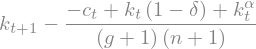

In [4]:
EK = ka - (f(kt) - ct + (1 - delta) * kt) / (1 + g) / (1 + n) 
EK

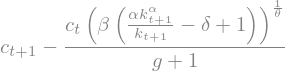

In [5]:
EC = ca - ct * (beta * (f(ka).diff(ka) + 1 - delta)) ** (1 / theta) / (1 + g)
EC

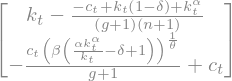

In [6]:
E = sp.Matrix([EK, EC]).subs({ka: kt, ca: ct})
E

In [7]:
params = {
    alpha: 0.33,
    delta: 0.03,
    g: 0.02,
    n: 0.01,
    theta: 0.8,
    beta: 0.98
}

In [11]:
def solve_ss(eqm_k, eqm_c, param, x0):
    c, k = sp.symbols("c, k")
    eqm = sp.Matrix([eqm_k.subs({kt: k, ka: k, ct: c, ca: c}),
                     eqm_c.subs({kt: k, ka: k, ct: c, ca: c})])
    
    eqm_lam = sp.lambdify([[k, c]], np.squeeze(eqm.subs(param)))
    J_lam = sp.lambdify([[k, c]], eqm.jacobian([k, c]).subs(param))
    
    ss = fsolve(func=eqm_lam, x0=x0, fprime=J_lam)
    return ss


def solve_optimal_growth(eqm_k, eqm_c, k_init, c_final, param, T):
    
    c = sp.symbols(f"c[:{T+1}]")
    k = sp.symbols(f"k[:{T+1}]")
    eqm = sp.Matrix([[eqm_k.subs({kt: k[i], ka: k[i+1], ct: c[i], ca: c[i+1]}),
                      eqm_c.subs({kt: k[i], ka: k[i+1], ct: c[i], ca: c[i+1]})] 
                      for i in range(T)])
    eqm_col = eqm.T.reshape(2*T, 1)
    
    eqm_param = eqm_col.subs(param).subs({k[0]: k_init, c[-1]: c_final})
    eqm_param = np.squeeze(eqm_param)
    
    eqm_num = sp.lambdify([[*k[1:], *c[:-1]]], eqm_param)
    solution = fsolve(eqm_num, x0=np.ones(2*T))
    
    k_sol = np.r_[k_init, solution[:T]]
    c_sol = np.r_[solution[T:], c_final]
    
    return (k_sol, c_sol)

In [12]:
ss1 = solve_ss(EK, EC, params, x0=[4, 4])
ss1

array([10.87371171,  1.54328611])

In [14]:
k_sol, c_sol = solve_optimal_growth(EK, EC, 1.0, ss1[1], params, 80)

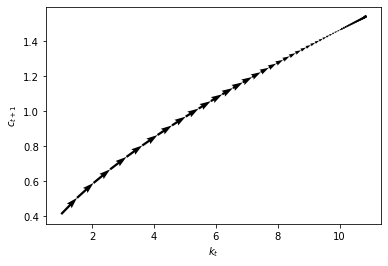

In [15]:
plt.quiver(k_sol[:-1], c_sol[:-1], 
           k_sol[1:] - k_sol[:-1], 
           c_sol[1:] - c_sol[:-1],
           scale_units='xy', angles='xy', scale=1)

plt.xlabel(r"$k_{t}$")
plt.ylabel(r"$c_{t}$")
plt.show()

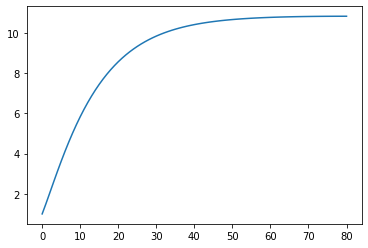

In [16]:
plt.plot(k_sol)

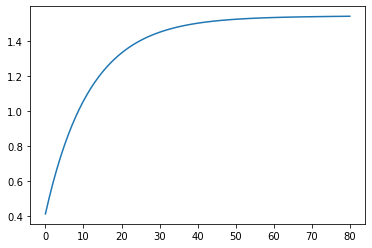

In [17]:
plt.plot(c_sol)